In [1]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
#from allensdk.core.reference_space import ReferenceSpace
#from allensdk.core.reference_space_cache import ReferenceSpaceCache
#from atlas_functions import *
#from MIFFE import search_path
#import ants
#import nrrd
import scipy
import cv2
from PIL import Image
import nrrd
from collections import OrderedDict
import tifffile as tiff
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

In [2]:
def convert_to_grayscale(input_file, output_file, frame_range):
    video = cv2.VideoCapture(input_file)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_file_template = output_file.replace('.tif', '_{}.tif')
    
    if frame_range[1] == -1:
        frame_range[1] = total_frames - 1
    
    current_frame = frame_range[0]
    file_counter = 0
    max_frame = min(12000, frame_range[1]-frame_range[0])
    while current_frame < frame_range[1]:
        output_file = output_file_template.format(file_counter)
        print(output_file)
        with tiff.TiffWriter(output_file, bigtiff=True) as tiff_writer:
            video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
            for _ in tqdm(range(max_frame)):
                ret, frame = video.read()

                # frame = frame[:, 420:1500]
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.uint8(bin_pixels(frame, 2))
                tiff_writer.write(frame, contiguous=True)
                
                current_frame += 1
                if current_frame > frame_range[1]:
                    break
                    
            file_counter += 1
            
    frame = None
    video.release()
    
    return None


def write_frame_difference(input_folder, input_file, output_file, frame_range, binning=False):
    video = cv2.VideoCapture(f"{input_folder}\\{input_file}")
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_range[1] == -1:
        frame_range[1] = total_frames - 1

    motion_energy = []
    frames_to_process = frame_range[1] - frame_range[0] + 1
    num_output_files = (frames_to_process + 11999) // 12000
    for file_counter in range(num_output_files):
        start_frame = frame_range[0] + file_counter * 12000
        end_frame = min(frame_range[0] + (file_counter + 1) * 12000 - 1, frame_range[1])
        num_frames_in_output = end_frame - start_frame + 1
        output_file_template = output_file.replace('.tif', f'_{file_counter}.tif')
        print(output_file_template)

        with tf.TiffWriter(output_file_template, bigtiff=True) as tiff_writer:
            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            ret, frame1 = video.read()
            frame1 = cv2.cvtColor(frame1[:, 420:1500], cv2.COLOR_BGR2GRAY)
            for current_frame in tqdm(range(start_frame, end_frame)):
                ret, frame2 = video.read()
                frame2 = cv2.cvtColor(frame2[:, 420:1500], cv2.COLOR_BGR2GRAY)
                
                diff_frame = cv2.absdiff(frame2, frame1)
                if binning:
                    diff_frame = bin_pixels(diff_frame, 2)
                tiff_writer.write(np.uint8(diff_frame), contiguous=True)
                motion_energy.append(np.mean(diff_frame))
                
                frame1 = frame2

    video.release()
    np.save(f"{input_folder}\\motion_energy", np.array(motion_energy))   
    
    return None


def remove_artefacts(input_folder, threshold):
    motion_energy_path = os.path.join(input_folder, 'motion_energy.npy')
    if os.path.exists(motion_energy_path):
        motion_energy = np.load(motion_energy_path)

        for idx, value in enumerate(motion_energy):
            if value < threshold:
                if idx == 0:
                    motion_energy[idx] = (value + motion_energy[idx + 1]) / 2
                elif idx == len(motion_energy) - 1:
                    motion_energy[idx] = (motion_energy[idx - 1] + value) / 2
                else:
                    motion_energy[idx] = (motion_energy[idx - 1] + motion_energy[idx + 1]) / 2

        np.save(motion_energy_path, motion_energy)
        motion_energy = None
    else:
        print(f"No 'motion_energy.npy' found in {input_folder}")

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.tif'):
            input_file = os.path.join(input_folder, file_name)

            with tf.TiffFile(input_file) as tif:
                frames = tif.asarray()
            
            for idx, frame in enumerate(frames):
                frame_mean = np.mean(frame)
                
                if frame_mean < threshold:
                    if idx == 0:
                        frames[idx] = (frame + frames[idx + 1]) // 2
                    elif idx == len(frames) - 1:
                        frames[idx] = (frames[idx - 1] + frame) // 2
                    else:
                        frames[idx] = (frames[idx - 1] + frames[idx + 1]) // 2
            
            tf.imwrite(input_file, frames)
            frames = None
            
    return None

def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    return binned_frame

In [3]:
input_file = '/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M34_8aout_video/CVR_M34_8aout_video.mp4'
output_file = '/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M34_8aout_video/CVR_M34_8aout_video.tif'

In [4]:
convert_to_grayscale(input_file, output_file, [0, -1])

/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M34_8aout_video/CVR_M34_8aout_video_0.tif


100%|█████████████████████████████████████| 12000/12000 [04:53<00:00, 40.88it/s]


/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M34_8aout_video/CVR_M34_8aout_video_1.tif


 93%|██████████████████████████████████▍  | 11166/12000 [04:26<00:19, 41.87it/s]


In [5]:
video = tiff.imread("/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M34_8aout_video/CVR_M34_8aout_video_0.tif")

In [6]:
video.shape

(12000, 540, 960)

In [7]:
mean_ts_cropped_video = np.mean(video[:, 320:405, 597:663], axis=(1,2))

AttributeError: module 'matplotlib.pyplot' has no attribute 'figsize'

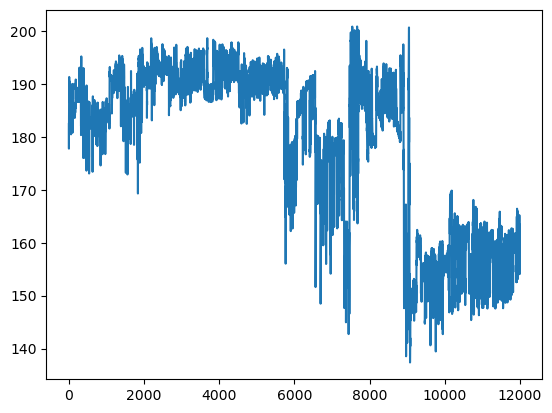

In [23]:
plt.plot(mean_ts_cropped_video)
plt.show()

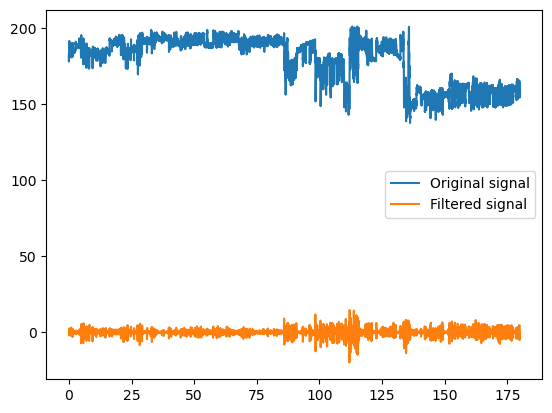

In [9]:
from scipy.signal import butter, filtfilt

# time vector
t = np.linspace(0, 180, len(mean_ts_cropped_video))

# Design the bandpass filter
#framerate_sampling
min_hz = 1
max_hz = 4
fs = 30
b, a = butter(4, [min_hz, max_hz], btype='band', fs=fs)

# Apply the bandpass filter to the signal
y = filtfilt(b, a, mean_ts_cropped_video)

# Plot the original and filtered signals
plt.plot(t, mean_ts_cropped_video, label='Original signal')
plt.plot(t, y, label='Filtered signal')
plt.legend()
plt.show()

# Filtering time

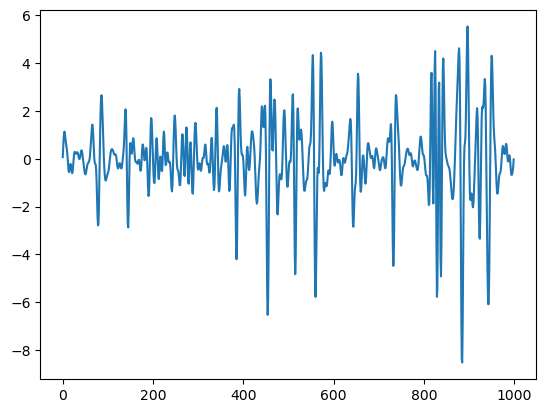

In [10]:
plt.plot(y[1000:2000])

In [11]:
fft_values = []
for a in range(50):
    fft_values.append(0)
for i in range(len(y)-100):
    fft_values.append(np.max(np.real(np.fft.fft(y[i:i+100])[:200])))
for b in range(50):
    fft_values.append(0)
ffts = np.array(fft_values)
gaussian_ffts = gaussian_filter1d(ffts, 5)

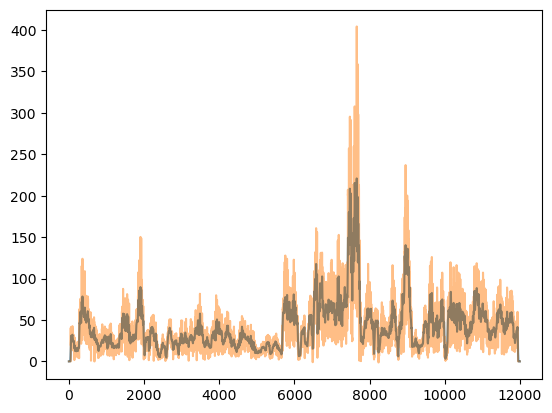

In [12]:
plt.plot(gaussian_ffts)
plt.plot(ffts, alpha=0.5)
plt.show()